### This is a test file for the data distillation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
BASE_DIR = '../Data/valid/'
os.listdir(BASE_DIR)
print('# Species in validation set:',len(os.listdir(BASE_DIR)))

# Species in validation set: 222


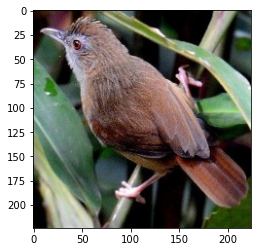

In [52]:
image = plt.imread(BASE_DIR+os.listdir(BASE_DIR)[0]+'/1.jpg')
plt.imshow(image)

image = tf.expand_dims(image,0)
image = tf.cast(image,tf.float32)
image = image / 255.0

#### 1. Data distillation with Pools / Lowering Resolution

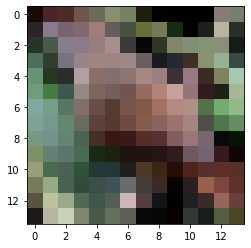

Dims: (1, 14, 14, 3)


In [4]:
class distiller(tf.keras.Model):
    def __init__(self):
        super(distiller, self).__init__()
        self.layer1 = tf.keras.layers.InputLayer(input_shape=(None,224,224,3))
        self.pool2 = tf.keras.layers.AveragePooling2D((15,15))

    def call(self, x):
        x = self.layer1(x)
        x = self.pool2(x)
        return x

example = distiller()

plt.imshow(tf.squeeze(example(image)))
plt.show()
print('Dims:',example(image).shape)

Does not make sense since this is what a CNN does anyways.

#### 2. Data distillation with Autoencoders (learning a distilled representation) 

In [49]:
class autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(autoencoder, self).__init__()
        
        self.encoder = [
            tf.keras.layers.InputLayer(input_shape=(None,224,224,3)),
            tf.keras.layers.Conv2D(filters=4,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=8,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=16,kernel_size=3,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim*latent_dim*3)
        ]

        self.decoder = [
            tf.keras.layers.Reshape(target_shape=(latent_dim,latent_dim,3)),
            tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=8,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=4,kernel_size=2,strides=2,padding='valid', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=2, padding='valid', activation='sigmoid'),
            tf.keras.layers.Reshape(target_shape=(224,224,3))
        ]

    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x

    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x

    @tf.function
    def call(self, input):
        x = self.encode(input)
        x = self.decode(x)
        return x

In [51]:
ae = autoencoder(latent_dim=14)

ae.build(input_shape=(None,224,224,3))
ae.compile(optimizer='adam', loss='mse')

In [46]:
ae.fit(image, image, epochs=10)

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 570ms/sample - loss: 0.0878
Epoch 2/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0877
Epoch 3/10
1/1 [==============================] - 0s 30ms/sample - loss: 0.0876
Epoch 4/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0874
Epoch 5/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0873
Epoch 6/10
1/1 [==============================] - 0s 32ms/sample - loss: 0.0871
Epoch 7/10
1/1 [==============================] - 0s 28ms/sample - loss: 0.0869
Epoch 8/10
1/1 [==============================] - 0s 33ms/sample - loss: 0.0867
Epoch 9/10
1/1 [==============================] - 0s 34ms/sample - loss: 0.0865
Epoch 10/10
1/1 [==============================] - 0s 31ms/sample - loss: 0.0861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


encoder (1, 224, 224, 3)
encoder (1, 111, 111, 4)
encoder (1, 55, 55, 8)
encoder (1, 27, 27, 16)
encoder (1, 11664)
encoder (1, 588)
0.11204228


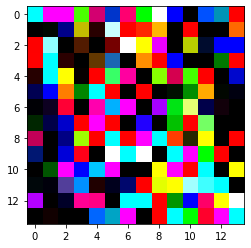

In [48]:
generated_image = ae.encode(image).numpy()

print(np.mean(generated_image))

plt.imshow(generated_image.reshape(14,14,3))

#### Training for the autoencoder (cross validation)

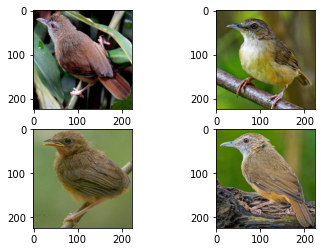

In [59]:
for i in range(4):
    plt.subplot(2,2,i+1)
    image = plt.imread(BASE_DIR+os.listdir(BASE_DIR)[0]+f'/{i+1}.jpg')
    plt.imshow(image)